In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bluetooth-speakers-dataset-from-flipkart:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2874276%2F4956294%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T012238Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9b237b15d62c673613537f5b01a4dd916df985e5c78c934c42ab43fa1f97f684da424044f0931999c06de6921633ca024f21309045e996f661a4301c109a37f37490683911bae4543d1c0d3ca822232a03ad4c0662d656f03c8551772eeca05371ed219ef7159cfe21c7adf70d50acbfca9cfc143075a410d6ede42180c60268aac525ed039cb96eee392d7402656ecea1c49163cb6968ffb56025346f1989a73eaacdcb799c661e4d2a0b332298f52ebc1f3c89f097def7c28218b89ebc57c18bc6c60d709b24bc272a283968e17a5b4dcc0e0ebfbcc4a9b6c2431eb3ebb9f4aab7e576af80424ea0f65e78996b9ca5776a070109e0c4de6a2d1d9eecd6d064'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347825 bytes downloaded
Downloaded and uncompressed: bluetooth-speakers-dataset-from-flipkart
Data source import complete.


In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
import pandas as pd

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df=pd.read_csv("/kaggle/input/bluetooth-speakers-dataset-from-flipkart/Bluetooth-speakers.csv",encoding="unicode_escape")
df.head()

,product_name,Rate,Review,Summary
0,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Wonderful,Super bass are very good and sound quality als...
1,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Awesome,Super qality best design. I loved it. Even my ...
2,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Excellent,According to the price Bass Quality is decent....
3,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Classy product,boAt is my all time fav and this is one of the...
4,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Classy product,This is best home theatre ?ø???????ø?????? so...


<ipython-input-10-d478e00bd950>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Rate', y='Sentiment', inner='box', palette='Dark2')


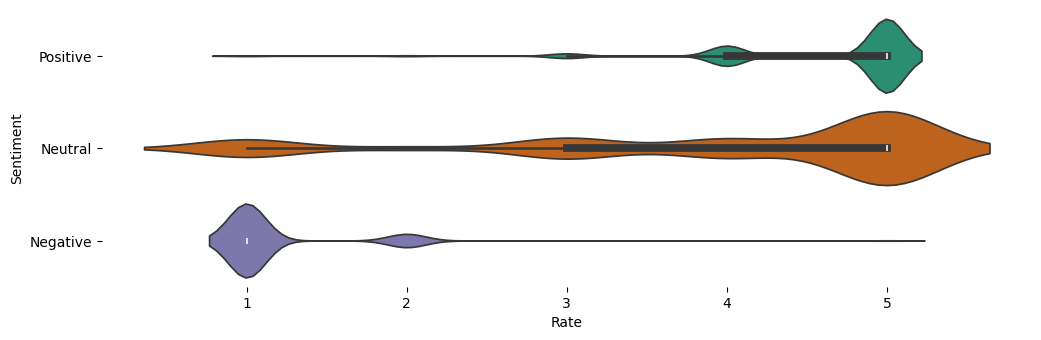

In [ ]:
# @title Sentiment vs Rate

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Rate', y='Sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

#### We do sentiment based on review, you can also do based on summary.

In [ ]:
sentiments = SentimentIntensityAnalyzer()
df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["Review"]]
df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["Review"]]
df["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df["Review"]]
df['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in df["Review"]]
#df.head()

In [ ]:
score = df["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df["Sentiment"] = sentiment
df.head()

,product_name,Rate,Review,Summary,Positive,Negative,Neutral,Compound,Sentiment
0,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Wonderful,Super bass are very good and sound quality als...,1.000,0.0,0.000,0.5719,Positive
1,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Awesome,Super qality best design. I loved it. Even my ...,1.000,0.0,0.000,0.6249,Positive
2,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Excellent,According to the price Bass Quality is decent....,1.000,0.0,0.000,0.5719,Positive
3,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Classy product,boAt is my all time fav and this is one of the...,0.744,0.0,0.256,0.4404,Positive
4,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Classy product,This is best home theatre ?ø???????ø?????? so...,0.744,0.0,0.256,0.4404,Positive


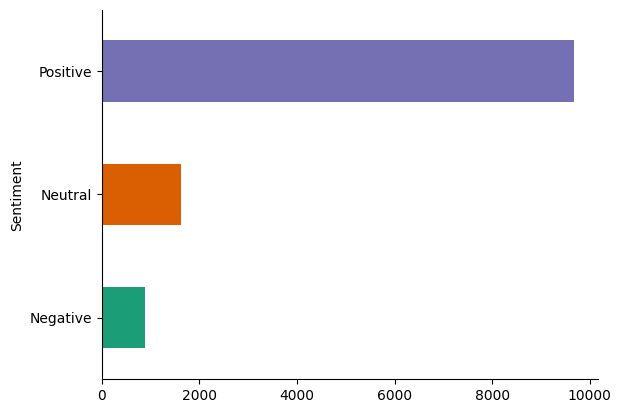

In [ ]:
# @title Sentiment

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-14-d478e00bd950>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Rate', y='Sentiment', inner='box', palette='Dark2')


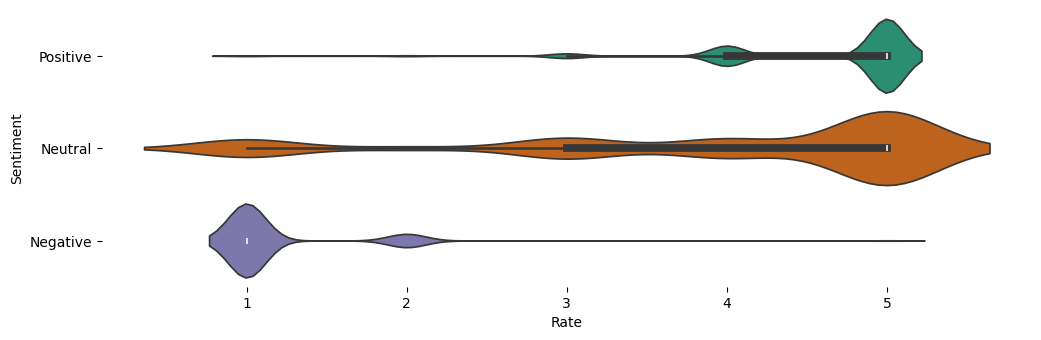

In [ ]:
# @title Sentiment vs Rate

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Rate', y='Sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

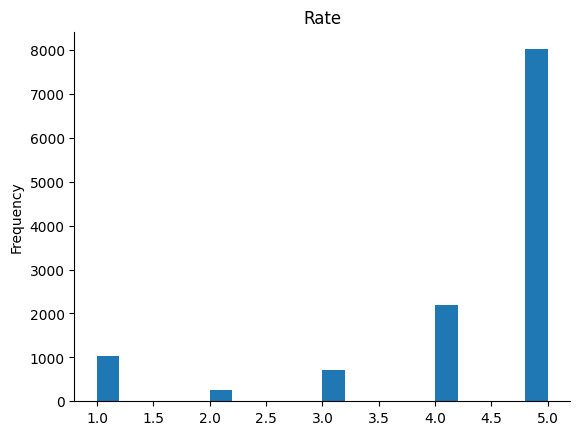

In [ ]:
# @title Rate

from matplotlib import pyplot as plt
df['Rate'].plot(kind='hist', bins=20, title='Rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: >

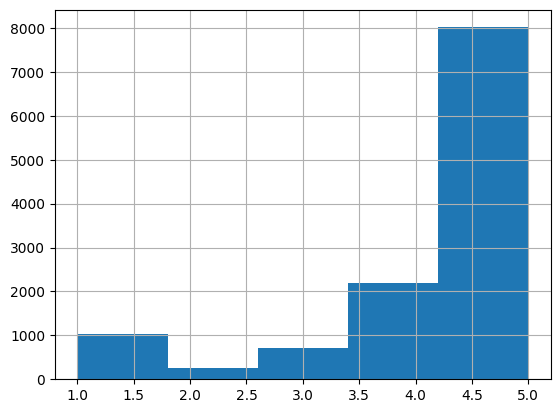

In [ ]:
# @title Review Rating Distribution

df['Rate'].hist(bins=5)

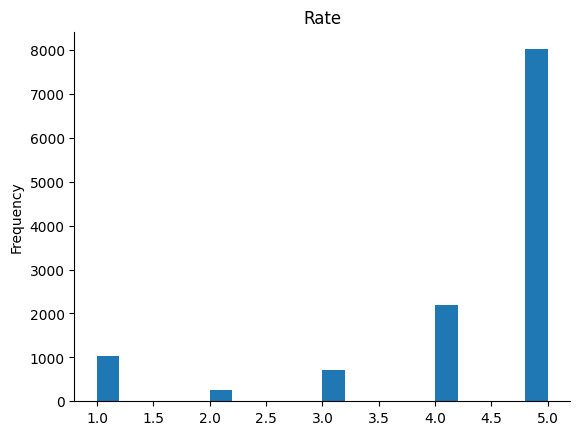

In [ ]:
# @title Rate

from matplotlib import pyplot as plt
df['Rate'].plot(kind='hist', bins=20, title='Rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.drop(df.columns[[4, 5, 6, 7]], axis=1, inplace=True)
df

,product_name,Rate,Review,Summary,Sentiment
0,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Wonderful,Super bass are very good and sound quality als...,Positive
1,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Awesome,Super qality best design. I loved it. Even my ...,Positive
2,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Excellent,According to the price Bass Quality is decent....,Positive
3,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Classy product,boAt is my all time fav and this is one of the...,Positive
4,boAt Blitz 1500 Multimedia 50 W Bluetooth Home...,5,Classy product,This is best home theatre ?ø???????ø?????? so...,Positive
...,...,...,...,...,...
12197,F FERONS Wireless rechargeable portable Premiu...,5,Just wow!,nice sound,Positive
12198,F FERONS Wireless rechargeable portable Premiu...,5,Worth every penny,According to price product is good ?ø?????,Positive
12199,F FERONS Wireless rechargeable portable Premiu...,3,Does the job,"Worst part is when you on it, sounds so loud s...",Neutral
12200,F FERONS Wireless rechargeable portable Premiu...,3,Just okay,Good,Positive


#### You can save your new .csv file through this command and download.

In [ ]:
df.to_csv('new_bluetooth-speakers.csv')

In [ ]:
df.shape

(12202, 5)

#### We count sentiment categories value

In [ ]:
df.Sentiment.value_counts()

Sentiment
Positive    9681
Neutral     1633
Negative     888
Name: count, dtype: int64

So there are 9861 Positive, 1633 neutral and 888 negative values available.